In [13]:
%matplotlib inline
%autoreload 2 

In [14]:
from __future__ import (division, absolute_import,
                        print_function, unicode_literals)
from IPython.html.widgets import interact

In [15]:
import george
import pandas as pd
import matplotlib.pyplot as plt
from george.kernels import (KappaKappaExpSquaredKernel, 
                            KappaGamma1ExpSquaredKernel,
                            KappaGamma2ExpSquaredKernel,
                            Gamma1Gamma1ExpSquaredKernel,
                            Gamma1Gamma2ExpSquaredKernel,
                            Gamma2Gamma2ExpSquaredKernel,
                            ExpSquaredKernel)
from collections import OrderedDict

In [16]:
import sys
sys.path.append("../")
import sample_and_fit_gp as fit
import diag_plots as plot

put them all inside a dictionary for easy iteration 

In [17]:
Kernels = OrderedDict({})
Kernels[KappaKappaExpSquaredKernel.__name__[:-16]] = \
        KappaKappaExpSquaredKernel

Kernels[KappaGamma1ExpSquaredKernel.__name__[:-16]] = \
        KappaGamma1ExpSquaredKernel

Kernels[KappaGamma2ExpSquaredKernel.__name__[:-16]] = \
        KappaGamma2ExpSquaredKernel
 
Kernels[Gamma1Gamma1ExpSquaredKernel.__name__[:-16]] = \
        Gamma1Gamma1ExpSquaredKernel
    
Kernels[Gamma1Gamma2ExpSquaredKernel.__name__[:-16]] = \
        Gamma1Gamma2ExpSquaredKernel
    
Kernels[Gamma2Gamma2ExpSquaredKernel.__name__[:-16]] = \
        Gamma2Gamma2ExpSquaredKernel

In [18]:
subplot_no = [1, 2, 3, 5, 6, 9]
titles = [r"$\kappa\kappa$", 
              r"$\kappa\gamma_1$",
              r"$\kappa\gamma_2$",
              r"$\gamma_1\gamma_1$",
              r"$\gamma_1\gamma_2$",
              r"$\gamma_2\gamma_2$"]

In [35]:
def initialize_GP_and_plot_deriv_kernels(inv_lambda, l_sq):     
    GPs = OrderedDict({})
    coords = np.array([[1, i] for i in np.linspace(0, 1, 10)])
    
    i = 0
    plt.figure(figsize=(10, 10))
    for k, v in Kernels.iteritems():
        GPs[k] = george.GP(inv_lambda * v([l_sq, l_sq], ndim=2))
        sample_mtx = GPs[k].get_matrix(coords) 
        sample_mtx += np.eye(10) * 1e-8
        sample_mtx /= inv_lambda
        
        pos_def = np.linalg.slogdet(sample_mtx)[0]
        # print(sample_mtx)
        
        sample_mtx *= inv_lambda
        #print(np.eye(10)) 
        
        if pos_def == 1.:
            color = 'b'  # blue means positive definite matrix
        else:
            color = 'r'
        
        # print(sample_mtx)
        plt.subplot(3, 3, subplot_no[i])
        plt.plot(range(coords.shape[0]), sample_mtx[:, 4], 'x-',
                 color=color, mew=2)
        plt.ylim(0, 4)
        plt.figtext(.45, .5, 
                    r"$\rho = ${0:.3e}".format(np.exp(-4 / l_sq)),
                    fontsize=20)
        plt.yticks(fontsize='small')
        plt.xticks(fontsize='small')
        plt.title(titles[i], fontsize=15) #titles[i])
        
        i += 1
    plt.show()
    

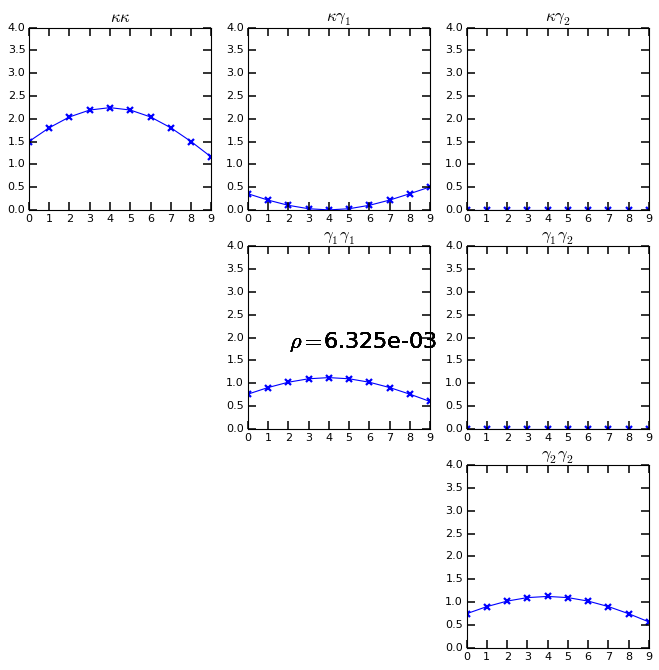

<function __main__.initialize_GP_and_plot_deriv_kernels>

In [36]:
interact(initialize_GP_and_plot_deriv_kernels, inv_lambda=(0.1, 1.5, 0.1),
         l_sq = (0.1, 1.5, 0.01))

In [33]:
def initialize_GP_and_plot_Schur_com_matrices(inv_lambda, l_sq):     
    GPs = OrderedDict({})
    coords = np.array([[1, i] for i in np.linspace(0, 1, 10)])
    
    i = 0
    # plt.figure(figsize=(10, 10))
    for k, v in Kernels.iteritems():
        GPs[k] = george.GP(inv_lambda * v([l_sq, l_sq], ndim=2))
    
    # Compute the Schur complement
    Sigmas = OrderedDict({})
    fig = plt.figure()
    Sigmas["KappaKappa"] = \
        np.matrix(GPs["KappaKappa"].get_matrix(coords))
    Sigmas["KappaGamma1"] = \
        np.matrix(GPs["KappaGamma1"].get_matrix(coords))
    Sigmas["Gamma1Gamma1"] = \
        np.matrix(GPs["Gamma1Gamma1"].get_matrix(coords))
    sec_term = np.dot(Sigmas["KappaGamma1"], 
                      np.dot(np.linalg.inv(Sigmas["Gamma1Gamma1"]), 
                             Sigmas["KappaGamma1"]))
    Schur_com = Sigmas["KappaKappa"] - sec_term
    Schur_pos_def = np.linalg.slogdet(Schur_com)[0]
    if Schur_pos_def == 1.:
        color = 'blue'
    else:
        color = 'red'

    
    # print(sample_mtx)
    i = 0
    for k, v in Sigmas.iteritems():
        plt.subplot(2, 2, i + 1)
        plt.plot(range(coords.shape[0]), v[:, 4], 'x-',
                 color=color, mew=2)
        plt.ylim(0, 7)
        plt.yticks(fontsize='small')
        plt.xticks(fontsize='small')
        plt.title(k, fontsize=15) #titles[i])    
        i += 1
        
    plt.subplot(2, 2, 4)
    plt.title("Schur complement")
    plt.plot(range(Schur_com.shape[0]), Schur_com[:, 4], 'x-',
                 color=color, mew=2)
    plt.figtext(.2, .8, 
                r"$\rho = ${0:.3e}".format(np.exp(-4 / l_sq)),
                fontsize=15)
    #plt.ylabel("Schur Cov matrix [i, 4]")

    plt.yticks(fontsize='small')
    plt.xticks(fontsize='small')

<function __main__.initialize_GP_and_plot_Schur_com_matrices>

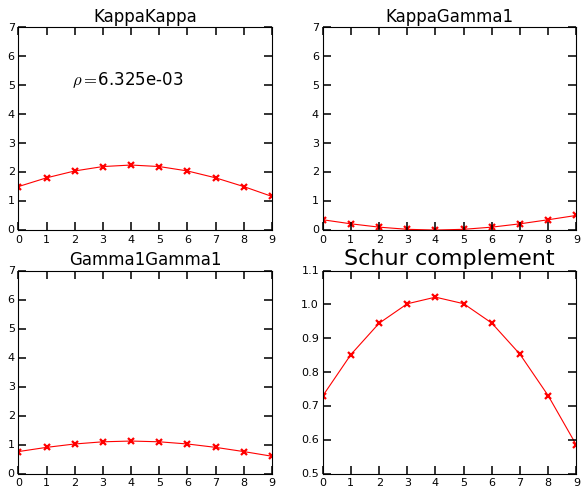

In [34]:
interact(initialize_GP_and_plot_Schur_com_matrices, 
         inv_lambda=(0.1, 1.5, 0.1),
         l_sq = (0.1, 1.5, 0.01))

Schur complement matrix may not be positive definite starting 
from $l^2 > 0.54$

In [39]:
def initialize_GP_and_plot_Schur_com(inv_lambda, l_sq):     
    GPs = OrderedDict({})
    coords = np.array([[1, i] for i in np.linspace(0, 1, 10)])
    
    i = 0
    # plt.figure(figsize=(10, 10))
    for k, v in Kernels.iteritems():
        GPs[k] = george.GP(inv_lambda * v([l_sq, l_sq], ndim=2))
    
    # Compute the Schur complement
    fig = plt.figure()
    sigma_KK = np.matrix(GPs["KappaKappa"].get_matrix(coords))
    sigma_KG = np.matrix(GPs["KappaGamma1"].get_matrix(coords))
    sigma_GG = np.matrix(GPs["Gamma1Gamma1"].get_matrix(coords))
    sec_term = np.dot(sigma_KG, np.dot(np.linalg.inv(sigma_GG), sigma_KG))
    Schur_com = sigma_KK - sec_term
    Schur_pos_def = np.linalg.slogdet(Schur_com)[0]
    if Schur_pos_def == 1.:
        color = 'blue'
    else:
        color = 'red'
    plt.clf()
    # plt.figure(figsize=(8, 6))
    plt.title("Schur complement")
    plt.plot(range(Schur_com.shape[0]), Schur_com[:, 4], 'x-',
                 color=color, mew=2)
    plt.figtext(.45, .5, 
                    r"$\rho = ${0:.2e}".format(np.exp(-4 / l_sq)),
                    fontsize=20)
    plt.ylim(0, 5.)
    plt.ylabel("Schur Cov matrix [i, 4]")
    plt.xlabel("index i")

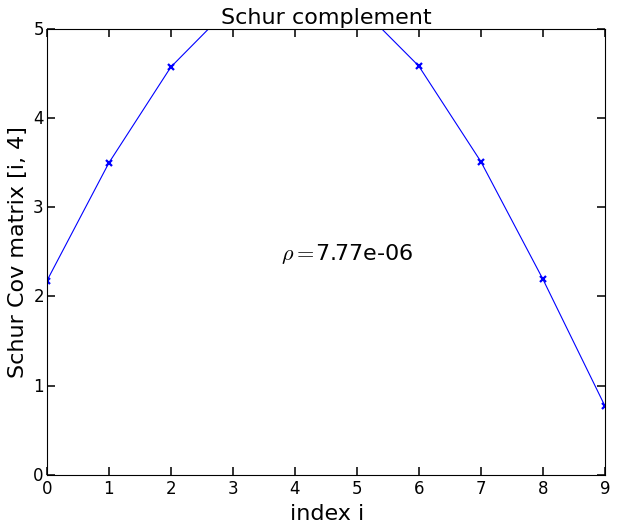

In [40]:
interact(initialize_GP_and_plot_Schur_com, inv_lambda=(0.1, 1.5, 0.1),
         l_sq = (0.1, 1.5, 0.01))